In [74]:
# from IPython.display import HTML
# HTML('''
# <script>
#   function code_toggle() {
#     if (code_shown){
#       $('div.input').hide('500');
#       $('#toggleButton').val('Show Code')
#     } else {
#       $('div.input').show('500');
#       $('#toggleButton').val('Hide Code')
#     }
#     code_shown = !code_shown
#   }

#   $( document ).ready(function(){
#     code_shown=false;
#     $('div.input').hide()
#   });
# </script>
# <form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>
# <script>
#   $(document).ready(function(){
#     $('div.prompt').hide();
#     $('div.back-to-top').hide();
#     $('nav#menubar').hide();
#     $('.breadcrumb').hide();
#     $('.hidden-print').hide();
#   });
# </script>

# <!---
# <footer id="attribution" style="float:right; color:#999; background:#fff;">
# Created with Jupyter, delivered by Fastly, rendered by Rackspace.
# </footer>
# -->
# ''')

# Horizontal surface velocities
ADCP measurements are aggregated and averaged over the period of the CTD cast. Then, the ADCP velocities are averaged over a certain depth (100 dBar and the mixed layer depth) and the according standard deviation of the velocity over that depth is determined.

In [1]:
%run ../../_setup.py

import warnings
warnings.filterwarnings('ignore')

from netCDF4 import Dataset, num2date
import xarray as xr

import math
import numpy as np
from scipy.interpolate import griddata
# from pandas import to_datetime
# from scipy.interpolate import UnivariateSpline
# from gsw import sigma0, f, grav
import pyproj

from OceanPy.interpolation import OI
from OceanPy.stability import mixed_layer_depth
# from OceanPy.animations import play2D
from OceanPy.kinematics import gradient_balance_from_ssh

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
# from matplotlib import rc

import cmocean as cmo

# import datetime


In [2]:
savefig = False

## ADCP velocities (at CTD locations) from surface to 100 dbar
The ADCP velocities are averaged over the first 100 dBar and the according standard deviation over that depth is determined by calculating the velocity magnitude, average it over the depth and calculating the standard deviation over the depth, which is than plotted as circles around the averaged velocity vectors.

In [3]:
input_file_adcp = os.path.join(datadir, 'processed', 'ss9802', 'adcp', 'ss9802_adcp_ctd.nc')
input_file_ctd = os.path.join(datadir, 'processed', 'ss9802', 'ctd', 'ss9802_ctd_gsw.nc')

adcp = Dataset(input_file_adcp)
ctd = Dataset(input_file_ctd)

nst = ctd.dimensions['profile'].size

# find index of pressure closest to predefined pressure level
plevel = 100
pressure = np.linspace(np.nanmin(adcp['p'][:]), np.nanmax(adcp['p'][:]), 
                       adcp.dimensions['plevel'].size)
ip = (np.abs(pressure-plevel)).argmin()

# calculate mean of velocities from surface to pressure level
utdmean = np.nanmean(adcp['u_ctd'][:, slice(0, ip)], axis=1)
vtdmean = np.nanmean(adcp['v_ctd'][:, slice(0, ip)], axis=1)

# calculate magnitude of vectors and calculate standard deviation
Vadcp = np.sqrt(adcp['u_ctd'][:]**2 + adcp['v_ctd'][:]**2)
V100mean = np.nanmean([Vadcp[ist, slice(0, ip)] for ist in range(nst)], axis=1)
V100std = np.nanstd([Vadcp[ist, slice(0, ip)] for ist in range(nst)], axis=1)


In order to see if the ADCP velocity vectors follow the geostrophic current, the linearly interpolated dynamic height contours between 1500-1000 dbar are plotted in the background.

In [4]:
# find indices for pressure levels in CTD prodiles
pressure_levels = {}
for ip, p in enumerate(ctd['p'][:]):
    pressure_levels[p] = ip

# define reference and interest level 
p_ref = 1500
p_int = 500
p_surf = 2

# get dynamic height contours
D = np.array([ctd['deltaD'][profile, pressure_levels[p_int]] / 
              ctd['g'][profile, pressure_levels[p_int]]
              for profile in range(len(ctd.dimensions['profile']))])

D_s = np.array([ctd['deltaD'][profile, pressure_levels[p_surf]] / 
              ctd['g'][profile, pressure_levels[p_surf]]
              for profile in range(len(ctd.dimensions['profile']))])

# find finite values
mask = np.isfinite(D[2:])

# interpolate linearly dynamic height contours on grid
lon, lat = ctd['lon'][2:, 1], ctd['lat'][2:, 1]
nx, ny = 20, 20
xi = np.linspace(lon[mask].min(), lon[mask].max(), nx)
yi = np.linspace(lat[mask].min(), lat[mask].max(), ny)
xxD, yyD = np.meshgrid(xi, yi)
Dgrd = griddata((lon[mask], lat[mask]), D[2:][mask], (xxD, yyD), method='linear')
D_sgrd = griddata((lon[mask], lat[mask]), D_s[2:][mask], (xxD, yyD), method='linear')
# Vgrd = griddata((adcp['lon_ctd'][2:], adcp['lat_ctd'][2:]), vmagmean[2,:], (xx, yy), method='linear')


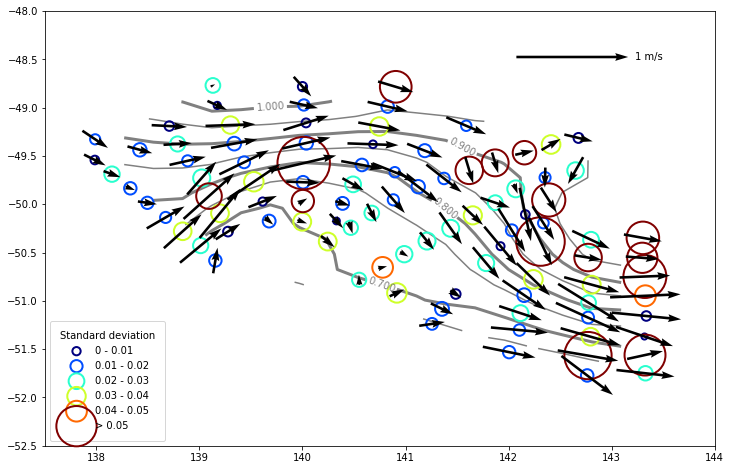

In [5]:
fig, ax = plt.subplots(figsize=(12, 8))

# plot dynamic height contours
step = 0.05
xmin, xmax = math.floor(np.nanmin(Dgrd)/step)*step, math.ceil(np.nanmax(Dgrd)/step)*step
nsteps = int((xmax - xmin) / step) + 2
bounds = np.linspace(xmin, xmax, nsteps)

ct = ax.contour(xxD, yyD, Dgrd, bounds, colors='gray', zorder=1)

def dh_cts(ct, bounds, ax=ax, start=0, end=-1, step=1):
    for ib, b in enumerate(bounds):
        if b in bounds[start:end:step]:
            zc = ct.collections[ib]
            plt.setp(zc, linewidth=3)
    ax.clabel(ct, bounds[start:end:step], inline=1, fontsize=10)
dh_cts(ct, bounds, step=2)

# plot quiver plot
Q = ax.quiver(adcp['lon_ctd'][2:], adcp['lat_ctd'][2:], utdmean[2:], vtdmean[2:], 
              pivot='mid', units='inches', width=0.003*12, zorder=3)
qk = plt.quiverkey(Q, 0.8, 0.8, 1, '1 m/s', labelpos='E', 
                   coordinates='figure', fontproperties={'size': 'medium'})

# # plot contour of veocity magnitude
# conf = plt.contourf(xx, yy, Vgrd, zorder=0)

# plot standard deviation scatter
std_bins = [0, 0.01, 0.02, 0.03, 0.04, 0.05]
colors = cm.jet(np.linspace(0, 1, len(std_bins)))
for i in range(len(std_bins)):
    if i == len(std_bins)-1:
        criteria = (V100std[2:] > std_bins[i])
        label = '> %s' % (std_bins[i])
    else:
        criteria = (V100std[2:] > std_bins[i]) & (V100std[2:] <= std_bins[i + 1])
        label = '%s - %s' % (std_bins[i], std_bins[i+1])
    ax.scatter(adcp['lon_ctd'][2:][criteria], adcp['lat_ctd'][2:][criteria], s=V100std[2:][criteria]*1e4, 
               label=label, color=colors[i], facecolors='none', linewidth=2, zorder=2)
legend = ax.legend(title='Standard deviation', borderpad=1, fontsize='medium', loc=3)
legend.get_title().set_fontsize('medium')

ax.set_xlim([137.5, 144]), ax.set_ylim([-52.5, -48])

plt.show()

As shown in the figure above the standard deviation is relatively large compared to when the velocity is averaged from the surface to the mixed layer depth, as seen in figure below.

In [6]:
smooth = True
imld = []
for ist in range(nst):
    
    # read variables
    sig0 = ctd['sigma0'][ist,]
    pt = ctd['pt'][ist,]
    z = ctd['z'][ist,]

    # determine index of mixed layer depth 
    imld_tdd = mixed_layer_depth(z, sig0=sig0, pt=pt, smooth=smooth)[0]
    imld.append(imld_tdd)
    
# construct adcp pressure levels
padcp = np.linspace(np.nanmin(adcp['p'][:]), np.nanmax(adcp['p'][:]), adcp.dimensions['plevel'].size)

# find reference depth
ref = 20
iref, ref_dep = min(enumerate(padcp), key=lambda x: abs(x[1] - ref))
print('reference depth: %s' %ref_dep)

# find pressure of mixed layer depth
pmld = [ctd['p'][i] for i in imld]
imldadcp = [(np.abs(padcp - p)).argmin() for p in pmld]

# calculate mean of velocities from surface to pressure level
umldmean = np.ma.masked_array([adcp['u_ctd'][ist, slice(iref, imldadcp[ist])].mean() for ist in range(nst)])
vmldmean = np.ma.masked_array([adcp['v_ctd'][ist, slice(iref, imldadcp[ist])].mean() for ist in range(nst)])

# calculate magnitude of vectors and calculate standard deviation
Vmldmean = np.ma.masked_array([Vadcp[ist, slice(iref, imldadcp[ist])].mean() for ist in range(nst)])
Vmldstd = np.ma.masked_array([Vadcp[ist, slice(iref, imldadcp[ist])].std()
                       if not all(Vadcp[ist, slice(iref, imldadcp[ist])].mask) else np.nan for ist in range(nst)])


reference depth: 16.8


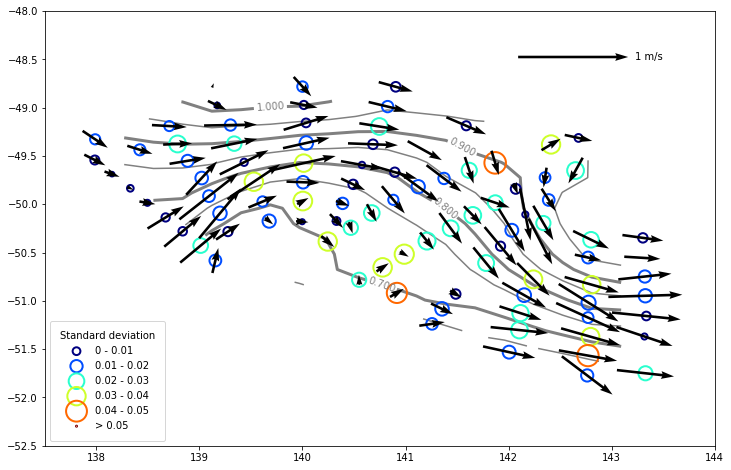

In [7]:
# PLOT

fig, ax = plt.subplots(figsize=(12, 8))

# plot dynamic height contours
ct = ax.contour(xxD, yyD, Dgrd, bounds, colors='gray', zorder=-1)
dh_cts(ct, bounds, step=2)

# plot quiver plot
Q = ax.quiver(adcp['lon_ctd'][2:], adcp['lat_ctd'][2:], umldmean[2:], vmldmean[2:], 
              pivot='mid', units='inches', width=0.003*12, zorder=2)
qk = plt.quiverkey(Q, 0.8, 0.8, 1, '1 m/s', labelpos='E', 
                   coordinates='figure', fontproperties={'size': 'medium'})

# plot standard deviation scatter
std_bins = [0, 0.01, 0.02, 0.03, 0.04, 0.05]
for i in range(len(std_bins)):
    if i == len(std_bins)-1:
        criteria = (Vmldstd[2:] > std_bins[i])
        label = '> %s' % (std_bins[i])
    else:
        criteria = (Vmldstd[2:] > std_bins[i]) & (Vmldstd[2:] <= std_bins[i + 1])
        label = '%s - %s' % (std_bins[i], std_bins[i+1])
    ax.scatter(adcp['lon_ctd'][2:][criteria], adcp['lat_ctd'][2:][criteria], s=Vmldstd[2:][criteria]*1e4, 
               label=label, color=colors[i], facecolors='none', linewidth=2, zorder=1)
legend = ax.legend(title='Standard deviation', borderpad=1, fontsize='medium', loc=3)
legend.get_title().set_fontsize('medium')

ax.set_xlim([137.5, 144]), ax.set_ylim([-52.5, -48])

plt.show()

## Geostrophic velocities and gradient velocities from SSH
Now, lets focus on the geostropic velocities. From SSH altimetry geostrophic velocities are determined, but are geostrophic velocities a good approximation to the true velocities or are gradient velocities a better approximation? Cushman-Roisin and Beckers, 2011, show that velocities in the trough and crest of meanders are significantly affected by the centrifugal force.

$$\kappa = \frac{-\eta_{xx}\eta_y^2 - \eta_{yy}\eta_x^2 + 2\eta_{xy}\eta_x\eta_y}{\left(\eta_x^2+\eta_y^2\right)^{3/2}}$$

In [8]:
# load altimetry data
input_file = os.path.join(datadir, 'external', 'ssh', 'rep', 'rep_allsat_phy_l4_135_-60_160_-45_1998.nc')
ssh = xr.open_dataset(input_file)

UTM54 = pyproj.Proj('+proj=utm +zone=54F +south +ellps=WGS84 +datum=WGS84 +units=m +no_defs')
WGS84 = pyproj.Proj('+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs')

# select data range
west = 137
south = -52.4
east = 147
north = -48.25

# select time
timevoy = slice('1998-03-10', '1998-03-28')

ssh = ssh.sel(longitude=slice(west, east), latitude=slice(south, north), time=timevoy)

lon_ctd, lat_ctd = ctd['lon'][2:,0], ctd['lat'][2:][:,0]
time = num2date(ctd['time'][:, 0], ctd['time'].units)[2:]
time_str = [t.strftime('%Y-%m-%d') for t in time]


In [10]:
from gsw import f, grav

In [64]:
def gradient_wind_from_ssh(xr_ds, variables=('adt', 'ugos', 'vgos'), 
                           dimensions=('time', 'latitude', 'longitude'), transform=None):
    
    # take Absolute Dynamic Topography from SSH xarray
    adt = xr_ds[variables[0]] if hasattr(xr_ds, variables[0]) else xr_ds.copy()
    ugeos = xr_ds[variables[1]] if hasattr(xr_ds, variables[1]) else None
    vgeos = xr_ds[variables[2]] if hasattr(xr_ds, variables[2]) else None
    
    orientation = np.arctan(vgeos / ugeos)
    Vgeos = np.sqrt(ugeos**2 + vgeos**2)
    
    # transform polar to cartesian coordinate system
    if transform is not None:
        WGS84 = pyproj.Proj('+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs')
        lnln, ltlt = np.meshgrid(xr_ds[dimensions[2]].data, xr_ds[dimensions[1]].data)
        xx, yy = pyproj.transform(WGS84, transform, lnln, ltlt)
    else:
        xx, yy = np.meshgrid(xr_ds[dimensions[2]].data, xr_ds[dimensions[1]].data)
    
    shp = adt.shape

    gravity = grav(ltlt, p=0)
    fcor = f(ltlt)
    if adt.ndim != 2:
        gravity = np.broadcast_to(gravity, shp)
        fcor = np.broadcast_to(fcor, shp)

    detadx = np.ma.masked_all(shp)
    detady = detadx.copy()
    d2etadx2, d2etady2, d2etadxdy = detadx.copy(), detadx.copy(), detadx.copy()
    for it in range(len(xr_ds[dimensions[0]])):
        detadx[it,] = np.gradient(adt[it,])[1] / np.gradient(xx)[1]
        detady[it,] = np.gradient(adt[it,])[0] / np.gradient(yy)[0]

        d2etadxdy[it,] = np.gradient(detadx[it,])[0] / np.gradient(yy)[0]

        d2etadx2[it,] = np.gradient(detadx[it,])[1] / np.gradient(xx)[1]
        d2etady2[it,] = np.gradient(detady[it,])[0] / np.gradient(yy)[0]
        
    kappa = (-(d2etadx2*detady**2) -(d2etady2*detadx**2) + (2*d2etadxdy*detadx*detady)) / (detadx**2 + detady**2)**(3/2)
    Rcurv = 1 / kappa

    root = np.sqrt(((fcor**2 * Rcurv**2) / 4) + (fcor * Rcurv * Vgeos))
    
    Vgrad = np.ma.masked_all(shp).flatten()
    fcor, Vgeos, Rcurv, root = fcor.flatten(), Vgeos.data.flatten(), Rcurv.flatten(), root.flatten()
    for i in range(len(Vgrad)):
        # Northern Hemisphere
        if fcor[i] >= 0:
            if (Rcurv[i] < 0) & (Vgeos[i] > 0):
                Vgrad[i] = -(fcor[i] * Rcurv[i] / 2) - root[i]
            elif (Rcurv[i] > 0) & (Vgeos[i] > 0):
                Vgrad[i] = -(fcor[i] * Rcurv[i] / 2) + root[i]
            else:
                Vgrad[i] = np.nan
        # Southern Hemisphere
        elif fcor[i] < 0:
            if (Rcurv[i] < 0) & (Vgeos[i] > 0):
                Vgrad[i] = -(fcor[i] * Rcurv[i] / 2) + root[i]
            elif (Rcurv[i] > 0) & (Vgeos[i] > 0):
                Vgrad[i] = -(fcor[i] * Rcurv[i] / 2) - root[i]
            else:
                Vgrad[i] = np.nan
    
    Vgrad, Vgeos = Vgrad.reshape(shp), Vgeos.reshape(shp)
    ugrad, vgrad = Vgrad * np.cos(orientation), Vgrad * np.sin(orientation)
    xr_ds_new = xr.Dataset(data_vars={'Vgrad': (dimensions, Vgrad),
                                      'Vgeos': (dimensions, Vgeos),
                                      'orientation': (dimensions, orientation),
                                      'ugrad': (dimensions, ugrad),
                                      'vgrad': (dimensions, vgrad)},
                           coords={dimensions[0]: xr_ds[dimensions[0]],
                                   dimensions[1]: xr_ds[dimensions[1]],
                                   dimensions[2]: xr_ds[dimensions[2]]})

    return xr_ds_new

In [65]:
# from OceanPy.kinematics import gradient_wind_from_ssh

gw = gradient_wind_from_ssh(ssh, transform=UTM54)
# diff = ((Vgrad - Vgeos) / Vgeos) * 100

# ugrad.shape
# xr.DataArray(coords=, vars=)
# help(xr.DataArray)
gw

<xarray.Dataset>
Dimensions:      (latitude: 17, longitude: 40, time: 19)
Coordinates:
  * time         (time) datetime64[ns] 1998-03-10 1998-03-11 ... 1998-03-28
  * latitude     (latitude) float32 -52.375 -52.125 -51.875 ... -48.625 -48.375
  * longitude    (longitude) float32 137.125 137.375 137.625 ... 146.625 146.875
Data variables:
    Vgrad        (time, latitude, longitude) float64 0.2455 0.1942 ... 0.1063
    Vgeos        (time, latitude, longitude) float64 0.2456 0.1946 ... 0.1063
    orientation  (time, latitude, longitude) float64 0.1843 0.08284 ... 0.9917
    ugrad        (time, latitude, longitude) float64 0.2413 0.1935 ... 0.05816
    vgrad        (time, latitude, longitude) float64 0.04498 0.01607 ... 0.08895

In [46]:
loni, lati = ssh.longitude.data, ssh.latitude.data
lonlon, latlat = np.meshgrid(loni, lati)
xx, yy = pyproj.transform(WGS84, UTM54, lonlon, latlat)

detadx = np.ma.masked_all(ssh.adt.shape)
detady, detadxdy = detadx.copy(), detadx.copy()
d2etadxdy, d2etadx2, d2etady2 = detadx.copy(), detadx.copy(), detadx.copy()
for it in range(len(ssh.time)):
    detadx[it,] = np.gradient(ssh.adt[it,])[1] / np.gradient(xx)[1]
    detady[it,] = np.gradient(ssh.adt[it,])[0] / np.gradient(yy)[0]
    
    d2etadxdy[it,] = np.gradient(detadx[it,])[0] / np.gradient(yy)[0]
    
    d2etadx2[it,] = np.gradient(detadx[it,])[1] / np.gradient(xx)[1]
    d2etady2[it,] = np.gradient(detady[it,])[0] / np.gradient(yy)[0]
    
gravity = grav(latlat, p=0)
fcor = f(latlat)
fcor = np.broadcast_to(fcor, ssh.adt.shape)

ugeos = -(gravity / fcor) * detady
vgeos = (gravity / fcor) * detadx

orientation = np.arctan(vgeos / ugeos)
Vgeos = np.sqrt(ugeos**2 + vgeos**2)

kappa = (-(d2etadx2*detady**2) -(d2etady2*detadx**2) + (2*d2etadxdy*detadx*detady)) / (detadx**2 + detady**2)**(3/2)
Rcurv = 1 / kappa


hemisphere = 'NH' if np.all(fcor > 0) else 'SH'
root = np.sqrt(((fcor**2 * Rcurv**2) / 4) + (fcor * Rcurv * Vgeos))

# Vgrad = np.ma.masked_all(ssh.adt.shape)
# tt, ii, jj  = np.where(((1/kappa) < 0) & (Vgeos > 0))
# for (it, i, j) in zip(tt, ii, jj):
#     Vgrad[it, i, j] = -(fcor[i, j] * (1/kappa[it, i, j]) / 2) + root[it, i, j]

Vgrad = np.ma.masked_all(ssh.adt.shape).flatten()
fcor, Vgeos, Rcurv, root = fcor.flatten(), Vgeos.flatten(), Rcurv.flatten(), root.flatten()
count = 0
for i in range(len(Vgrad)):
    if (Rcurv[i] < 0) & (Vgeos[i] > 0):
        Vgrad[i] = -(fcor[i] * Rcurv[i] / 2) + root[i]
    elif (Rcurv[i] > 0) & (Vgeos[i] > 0):
        Vgrad[i] = -(fcor[i] * Rcurv[i] / 2) - root[i]
    else:
        Vgrad[i] = np.nan
Vgrad = Vgrad.reshape(ssh.adt.shape)

kappa = xr.DataArray(kappa, dims=['time', 'longitude', 'latitude'], coords=[ssh.time, ssh.latitude, ssh.longitude])
Vgeos = xr.DataArray(Vgeos.reshape(ssh.adt.shape), dims=['time', 'longitude', 'latitude'], coords=[ssh.time, ssh.latitude, ssh.longitude])
Vgrad = xr.DataArray(Vgrad.reshape(ssh.adt.shape), dims=['time', 'longitude', 'latitude'], coords=[ssh.time, ssh.latitude, ssh.longitude])

diff = ((Vgrad - Vgeos) / Vgeos) * 100
# trues[0].shape, trues[1].shape, trues[2].shape, ssh.adt.shape
# Vgrad[trues] = (-(fcor * (1/kappa) / 2) + root).data.flatten()

# true = np.where(((1/kappa) < 0) & (Vgeos > 0))
# len(true[0]), len(true[1]), len(true[2])
# Vgrad[true] = 1
# for it in range(ssh.adt.shape[0]):
#     print(true[it])
#             Vgrad[it, i, j] = -(fcor * (1/kappa) / 2) + root
# 
    
# kappa = xr.DataArray(kappa, dims=['time', 'longitude', 'latitude'], coords=[ssh.time, ssh.latitude, ssh.longitude])
# ugeos = xr.DataArray(ugeos, dims=['time', 'longitude', 'latitude'], coords=[ssh.time, ssh.latitude, ssh.longitude])


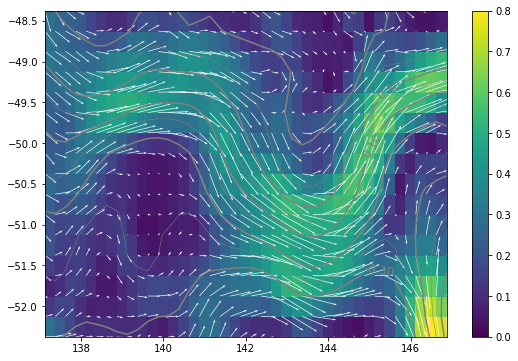

In [66]:
fs_small=12

fig, ax = plt.subplots(figsize=(9, 6))

# plot voyagemean ADT contours
bounds = [-0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5]
ct = ax.contour(ssh.longitude, ssh.latitude, ssh.adt.sel(time=timevoy).mean('time'), bounds, 
                colors='gray', linestyles='solid', linewidths=0.5)
for ib, b in enumerate(bounds):
    if b in bounds[0::2]:
        zc = ct.collections[ib]
        plt.setp(zc, linewidth=1.5)
manual = [(145.25, -51.5), (145, -50),  (145.5, -49.35)]

ax.clabel(ct, bounds[0::2], inline=1, fontsize=fs_small, fmt='%.2f', manual=manual)
pcol = ax.pcolor(ssh.longitude, ssh.latitude, gw.Vgrad.sel(time=timevoy).mean('time'), 
                 vmin=0, vmax=0.8, cmap=plt.cm.viridis)

quiv = ax.quiver(ssh.longitude, ssh.latitude, gw.ugrad.mean('time'), gw.vgrad.mean('time'), 
                 units='inches', scale=1, width=1e-3*fig.get_size_inches()[0], color='w')
fig.colorbar(pcol)

Calculate geostrophic and gradient velocities at CTD locations and compare results.

In [9]:
# %%time
lnln, ltlt = np.meshgrid(ssh.longitude, ssh.latitude)
lnln_flat, ltlt_flat = lnln.flatten(), ltlt.flatten()


V = np.ma.masked_all((len(ssh.time), len(lnln_flat)))
Vg, theta, ugos, vgos = V.copy(), V.copy(), V.copy(), V.copy()
for it in range(len(ssh.time)):
    for i, coord in enumerate(zip(lnln_flat, ltlt_flat)): # [80:85]
        V[it, i], Vg[it, i], theta[it, i], ugos[it, i], vgos[it, i] = gradient_balance_from_ssh(ssh, coord, time=ssh.time[it], transform=UTM54)

# ugr = V * np.cos(theta)
# vgr = V * np.sin(theta)

# ug = Vg * np.cos(theta)
# vg = Vg * np.sin(theta)

error: (m>k) failed for hidden m: fpcurf0:m=3

In [10]:
# %%time
V = np.ma.masked_all(len(lon_ctd))
Vg, theta, ugos, vgos = V.copy(), V.copy(), V.copy(), V.copy()
for i, coord in enumerate(zip(lon_ctd, lat_ctd)): # [80:85]
    V[i], Vg[i], theta[i], ugos[i], vgos[i] = gradient_balance_from_ssh(ssh, coord, time=time_str[i], transform=UTM54)

ugr = V * np.cos(theta)
vgr = V * np.sin(theta)

ug = Vg * np.cos(theta)
vg = Vg * np.sin(theta)

In [1]:
# V = np.ma.masked_all((len(ssh.time), len(lon_ctd)))
V = np.ma.masked_all(len(lon_ctd))
Vg, theta, ugos, vgos = V.copy(), V.copy(), V.copy(), V.copy()
# for it in range(len(ssh.time)):
for i, coord in enumerate(zip(lon_ctd, lat_ctd)): # [80:85]
#     V[it, i], Vg[it, i], theta[it, i], ugos[it, i], vgos[it, i] = gradient_balance_from_ssh(ssh, coord, time=ssh.time[it], transform=UTM54)
    V[i], Vg[i], theta[i], ugos[i], vgos[i] = gradient_balance_from_ssh(ssh, coord, time=time_str[i], transform=UTM54)

ugr = V * np.cos(theta)
vgr = V * np.sin(theta)

ug = Vg * np.cos(theta)
vg = Vg * np.sin(theta)


NameError: name 'np' is not defined

$$R^2 = 1 - \frac{\sum_{i=1}^n(y_i-f_i)^2}{\sum_{i=1}^n(y_i-\bar{y})^2}$$

In [11]:
# coefficient of determination
mask = Vmldmean[2:].mask | V.mask

SStot = np.sum((Vmldmean[2:][~mask] - np.mean(Vmldmean[2:]))**2)
SSres = np.sum((V[~mask] - Vmldmean[2:][~mask])**2)

Rsquared = 1 - (SSres/SStot)

<IPython.core.display.Javascript object>


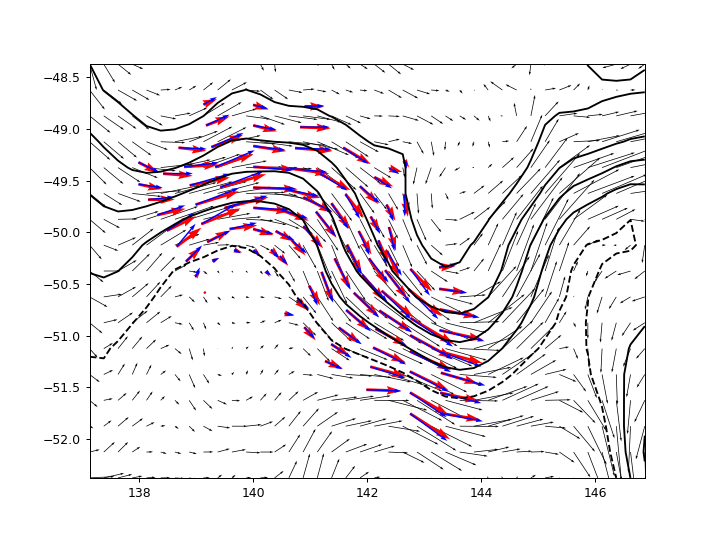

In [12]:
%matplotlib notebook
fig, ax = plt.subplots(figsize=(8, 6))
ax.contour(ssh.longitude, ssh.latitude, ssh.adt.mean('time'), [-0.15, 0, 0.15, 0.3, 0.45], colors='k')
quiv = ax.quiver(ssh.longitude, ssh.latitude, ssh.ugos.mean('time'), ssh.vgos.mean('time'), 
                 units='inches', scale=1, width=1e-3*fig.get_size_inches()[0], color='k')
quiv2 = ax.quiver(lon_ctd, lat_ctd, ugos, vgos, 
                  units='inches', scale=1, width=4e-3*fig.get_size_inches()[0], color='r')
quiv3 = ax.quiver(lon_ctd, lat_ctd, ugr, vgr, 
                  units='inches', scale=1, width=2e-3*fig.get_size_inches()[0], color='b')

<IPython.core.display.Javascript object>


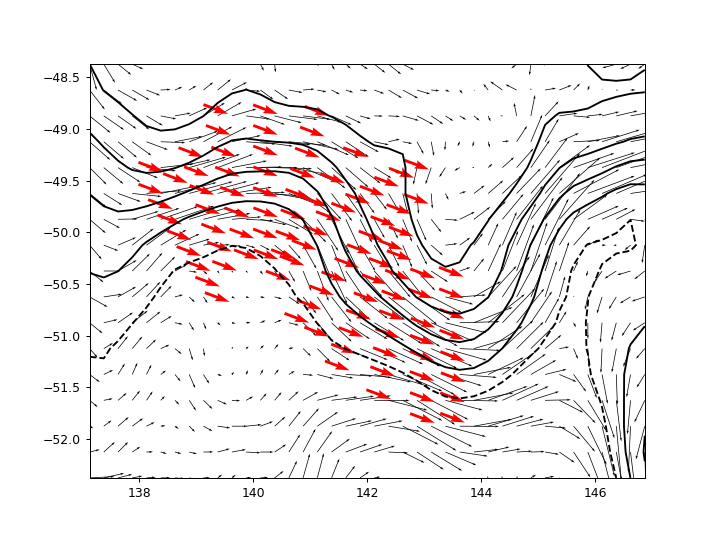

In [13]:
%matplotlib notebook
fig, ax = plt.subplots(figsize=(8, 6))
ax.contour(ssh.longitude, ssh.latitude, ssh.adt.mean('time'), [-0.15, 0, 0.15, 0.3, 0.45], colors='k')
quiv = ax.quiver(ssh.longitude, ssh.latitude, ssh.ugos.mean('time'), ssh.vgos.mean('time'), 
                 units='inches', scale=1, width=1e-3*fig.get_size_inches()[0], color='k')
quiv2 = ax.quiver(lon_ctd, lat_ctd, np.mean(ugos, axis=0), np.mean(vgos, axis=0), 
                  units='inches', scale=1, width=4e-3*fig.get_size_inches()[0], color='r')
quiv3 = ax.quiver(lon_ctd, lat_ctd, np.mean(ugr, axis=0), np.mean(vgr, axis=0), 
                  units='inches', scale=1, width=2e-3*fig.get_size_inches()[0], color='b')
fig.show()

<IPython.core.display.Javascript object>


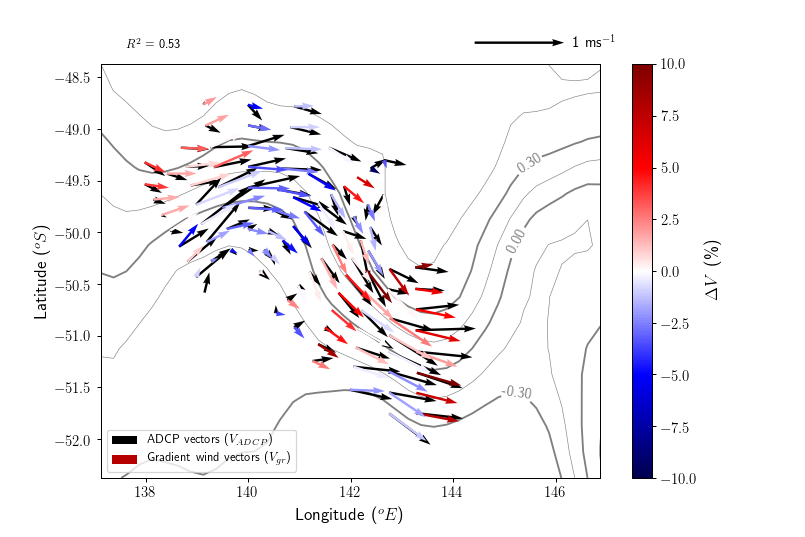

In [14]:
%matplotlib notebook
fs_small = 12
fs_large = 14
plt.rc('xtick',labelsize=fs_small)
plt.rc('ytick',labelsize=fs_small)
plt.rc('text', usetex=True)
# plt.rc('font', family='serif')

fig, ax = plt.subplots(figsize=(9, 6))

# plot voyagemean ADT contours
bounds = [-0.3, -0.15, 0, 0.15, 0.3, 0.45]
ct = ax.contour(ssh.longitude, ssh.latitude, ssh.adt.sel(time=timevoy).mean('time'), bounds, 
                colors='gray', linestyles='solid', linewidths=0.5)
for ib, b in enumerate(bounds):
    if b in bounds[0::2]:
        zc = ct.collections[ib]
        plt.setp(zc, linewidth=1.5)
manual = [(145.25, -51.5), (145, -50),  (145.5, -49.35)]
ax.clabel(ct, bounds[0::2], inline=1, fontsize=fs_small, fmt='%.2f', manual=manual)

# plot geostrophic velocity vectors
# quiv1 = ax.quiver(ssh.longitude, ssh.latitude, ssh.ugos.mean('time'), ssh.vgos.mean('time'),
#                   units='inches', scale=1, width=1e-3*fig.get_size_inches()[0], color='k')

# vmin, vmax = 0, 0.75
# axis=0
# pcol = ax.pcolor(Vgos.longitude, Vgos.latitude, Vgos.sel(time=timevoy).mean('time'), 
#                  vmin=vmin, vmax=vmax, cmap=cmo.cm.gray_r)

# plot adcp velocity vectors
quiv2 = ax.quiver(lon_ctd, lat_ctd, umldmean[2:], vmldmean[2:], 
                  units='inches', scale=1, width=3e-3*fig.get_size_inches()[0], zorder=2) # pivot='mid'
qk = plt.quiverkey(quiv2, 0.7, 0.92, 1, r'1 ms$^{-1}$', labelpos='E', coordinates='figure', 
                   fontproperties={'size': 'large'})
plt.text(0.05, 1.04, r'$R^2 = $ %s' %round(Rsquared,2), transform=ax.transAxes)
# plot gradient velocity vectors with color indication for velocity difference with geostrophic
# dV = np.mean(V-Vg, axis=0)
dV = ((V - Vg) / Vg) * 100
norm = mcolors.Normalize(vmin=-10,vmax=10)
cmap = plt.cm.seismic

quiv3 = ax.quiver(lon_ctd, lat_ctd, ugr, vgr, color=cmap(norm(dV)),
                  units='inches', scale=1, width=3e-3*fig.get_size_inches()[0], zorder=3)
# quiv3 = ax.quiver(lon_ctd, lat_ctd, np.mean(ugr, axis=0), np.mean(vgr, axis=0), color=cmap(norm(dV)),
#                   units='inches', scale=1, width=3e-3*fig.get_size_inches()[0], zorder=3)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.ax.set_ylabel(r'$\Delta V$ (\%)', fontsize=fs_large)

ax.set_xlabel(r'Longitude ($^oE$)', fontsize=fs_large)
ax.set_ylabel(r'Latitude ($^oS$)', fontsize=14)
# ct.set_label(r'hj')
quiv2.set_label(r'ADCP vectors ($V_{ADCP}$)')
quiv3.set_label(r'Gradient wind vectors ($V_{gr}$)')

ax.legend(loc=3)

# scat = ax.scatter(lon_ctd, lat_ctd, c=np.mean(V-Vg, axis=0), cmap=plt.cm.seismic, vmin=-0.04, vmax=0.04, s=100)
# fig.colorbar(scat)

In [13]:
if savefig:
    extensions = ['.png', '.pdf', '.eps']
    for extension in extensions:
        fig.savefig(os.path.join(figsdir, 'manuscripts', '01_manuscript', '02_surface-velocities' + extension))

Show geostrophic speed.

In [15]:
# load bathymetry (1 arc-minute resolution)
bathy = xr.open_dataset(os.path.join(datadir, 'external', 'bathymetry', 'smith_and_sandwell_1997', 
                             'bathymetry_-48_137_-58_157.nc'))
bathy = bathy.sel(longitude=slice(west, east), latitude=slice(north, south))

In [16]:
Vgos = np.ma.masked_all(ssh.ugos.shape)
for t in range(len(ssh.time)):
    Vgos[t,] = np.sqrt(ssh.ugos[t,]**2 + ssh.vgos[t,]**2)

Vgos = xr.DataArray(Vgos, dims=['time', 'latitude', 'longitude'], coords=[ssh.time, ssh.latitude, ssh.longitude])


<IPython.core.display.Javascript object>


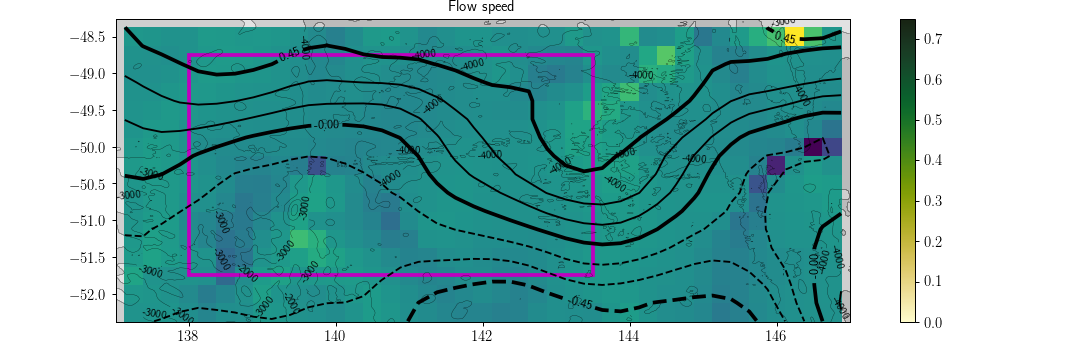

In [17]:
fig, ax = plt.subplots(figsize=(12,4))
fig.tight_layout()

# plot flow speed field
vmin, vmax = 0, 0.75
axis=0
pcol = ax.pcolor(Vgos.longitude, Vgos.latitude, Vgos.sel(time=timevoy).mean('time'), 
                 vmin=vmin, vmax=vmax, cmap=cmo.cm.speed)
plt.colorbar(pcol, ax=ax)
ax.set_title('Flow speed')

bounds = np.linspace(-0.45, 0.75, 9)
depths = np.linspace(-5000, -1000, 5)

    
# plot dynamic height contours
ct = ax.contour(Vgos.longitude, Vgos.latitude, ssh.adt.sel(time=timevoy).mean('time'), bounds, colors='k')
for ib, b in enumerate(bounds):
    if b in bounds[0::3]:
        zc = ct.collections[ib]
        plt.setp(zc, linewidth=3)
ax.clabel(ct, bounds[0::3], inline=1, fontsize=10, fmt='%.2f')

# plot depth contours
ax.contourf(bathy.longitude, bathy.latitude, bathy.depth, depths, 
                   cmap=plt.cm.binary_r, alpha=0.3)
dc = ax.contour(bathy.longitude, bathy.latitude, bathy.depth, depths, 
                   colors='k', linewidths=0.2, linestyles='solid')
ax.clabel(dc, depths, inline=1, fontsize=8, fmt='%.0f')

# plot observations domain
ax.fill([138, 143.5, 143.5, 138], [-51.75, -51.75, -48.75, -48.75], 
           facecolor='none', edgecolor='m', linewidth=3)

ax.set_aspect('equal')

In [16]:
input_file_ssh = os.path.join(datadir, 'external', 'ssh', 'SSH_OceanCurrent_137.5_-52_144_-48.5_199803.nc')
ssh = Dataset(input_file_ssh)

# lon, lat = adcp['lon_ctd'][2:], adcp['lat_ctd'][2:]
loni, lati = ssh['LONGITUDE'][:], ssh['LATITUDE'][:]
# lonlon, latlat = np.meshgrid(loni, lati)
# monthly mean ssh
ummean = np.mean(ssh['UCUR'][:], axis=0)
vmmean = np.mean(ssh['VCUR'][:], axis=0)

# monthly mean geostrophic velocity magnitude
Vssh = np.ma.masked_array([np.sqrt(ssh['UCUR'][t,::]**2 + ssh['UCUR'][t,::]**2) 
                        for t in range(ssh.dimensions['TIME'].size)])

Vmmean = np.mean(Vssh, axis=0)

The mixed layer depth velocities are used as observations in OI, with the monthly mean geostrophic velocities from SSH as a background field to obtain a field of absolute velocities on a rectangular grid. 

In [17]:
# optimal interpolation of ADCP velocities with SSH geostrophic velocities as background field
mask = np.ma.masked_invalid(umldmean[2:]).mask
xx, yy, u_b, u_a = OI(lon[~mask], lat[~mask], umldmean[2:][~mask],
                      Lx=(lon.max() - lon.min())/12, Ly=(lat.max() - lat.min())/14,
                      xx=loni, yy=lati, bg_fld=ummean)[0:4]
v_b, v_a = OI(lon[~mask], lat[~mask], vmldmean[2:][~mask],
              Lx=(lon.max() - lon.min())/12, Ly=(lat.max() - lat.min())/14,
              xx=loni, yy=lati, bg_fld=vmmean)[2:4]

Vmld_a = np.sqrt(u_a**2 + v_a**2)

First the velocity magnitude of the background and analysis field and for comparison the linear interpolated MLD velocity field is shown.

In [18]:
xx, yy = np.meshgrid(loni, lati)
mask = np.isfinite(Vmldmean[2:])
Vmld = griddata((lon[mask], lat[mask]), Vmldmean[2:][mask], (xx, yy), method='linear')

<IPython.core.display.Javascript object>


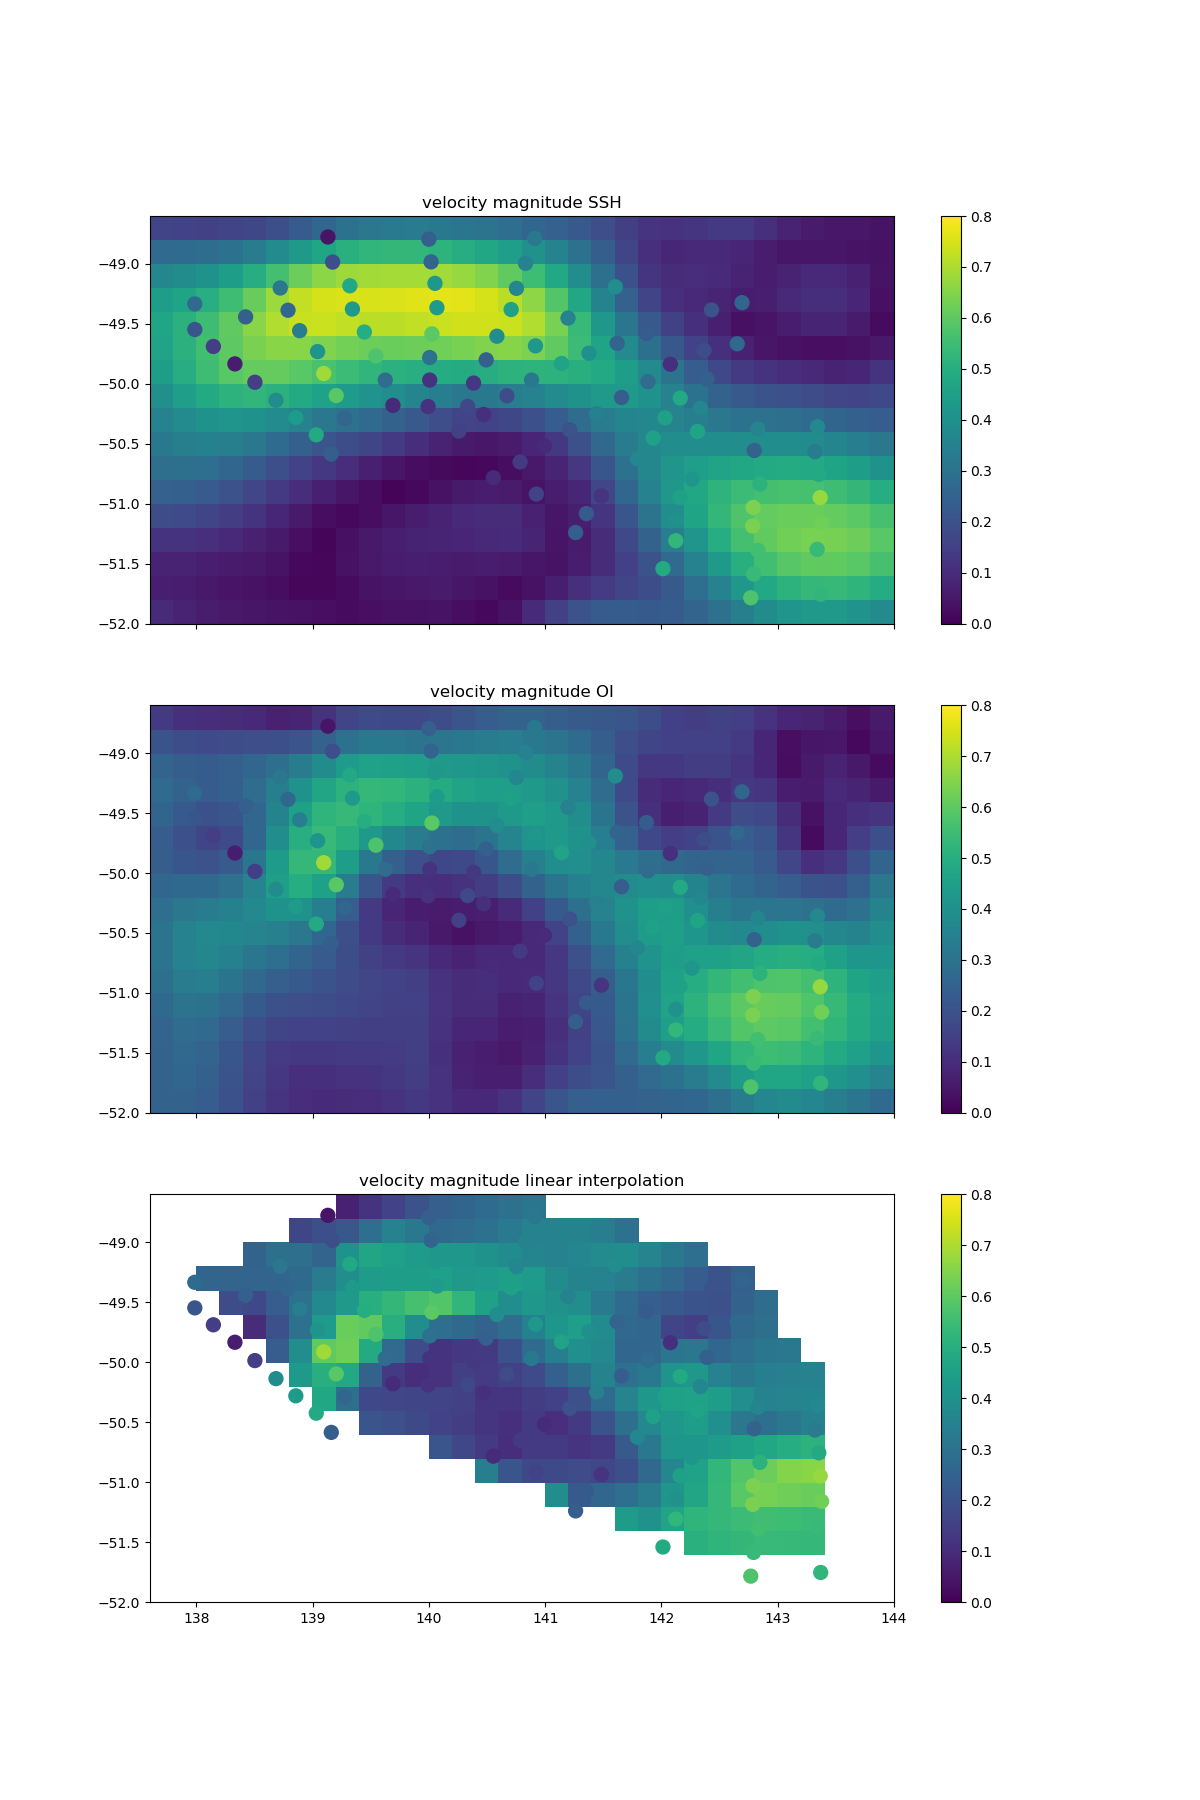

Text(0.5, 1.0, 'velocity magnitude linear interpolation')

In [19]:
fig, ax = plt.subplots(3, 1, figsize=(12, 18), sharex=True)
vmin, vmax = 0, 0.8
ax[0].pcolor(xx, yy, Vmmean.data, vmin=vmin, vmax=vmax)
scat = ax[0].scatter(lon, lat, c=Vmldmean[2:], s=100, vmin=vmin, vmax=vmax)
plt.colorbar(scat, ax=ax[0])
ax[0].set_title('velocity magnitude SSH')

ax[1].pcolor(xx, yy, Vmld_a, vmin=vmin, vmax=vmax)
scat = ax[1].scatter(lon, lat, c=Vmldmean[2:], s=100, vmin=vmin, vmax=vmax)
plt.colorbar(scat, ax=ax[1])
ax[1].set_title('velocity magnitude OI')

ax[2].pcolor(xx, yy, Vmld, vmin=vmin, vmax=vmax)
scat = ax[2].scatter(lon, lat, c=Vmldmean[2:], s=100, vmin=vmin, vmax=vmax)
plt.colorbar(scat, ax=ax[2])
ax[2].set_title('velocity magnitude linear interpolation')

Here, the u-component of the velocity vector is shown.

<IPython.core.display.Javascript object>


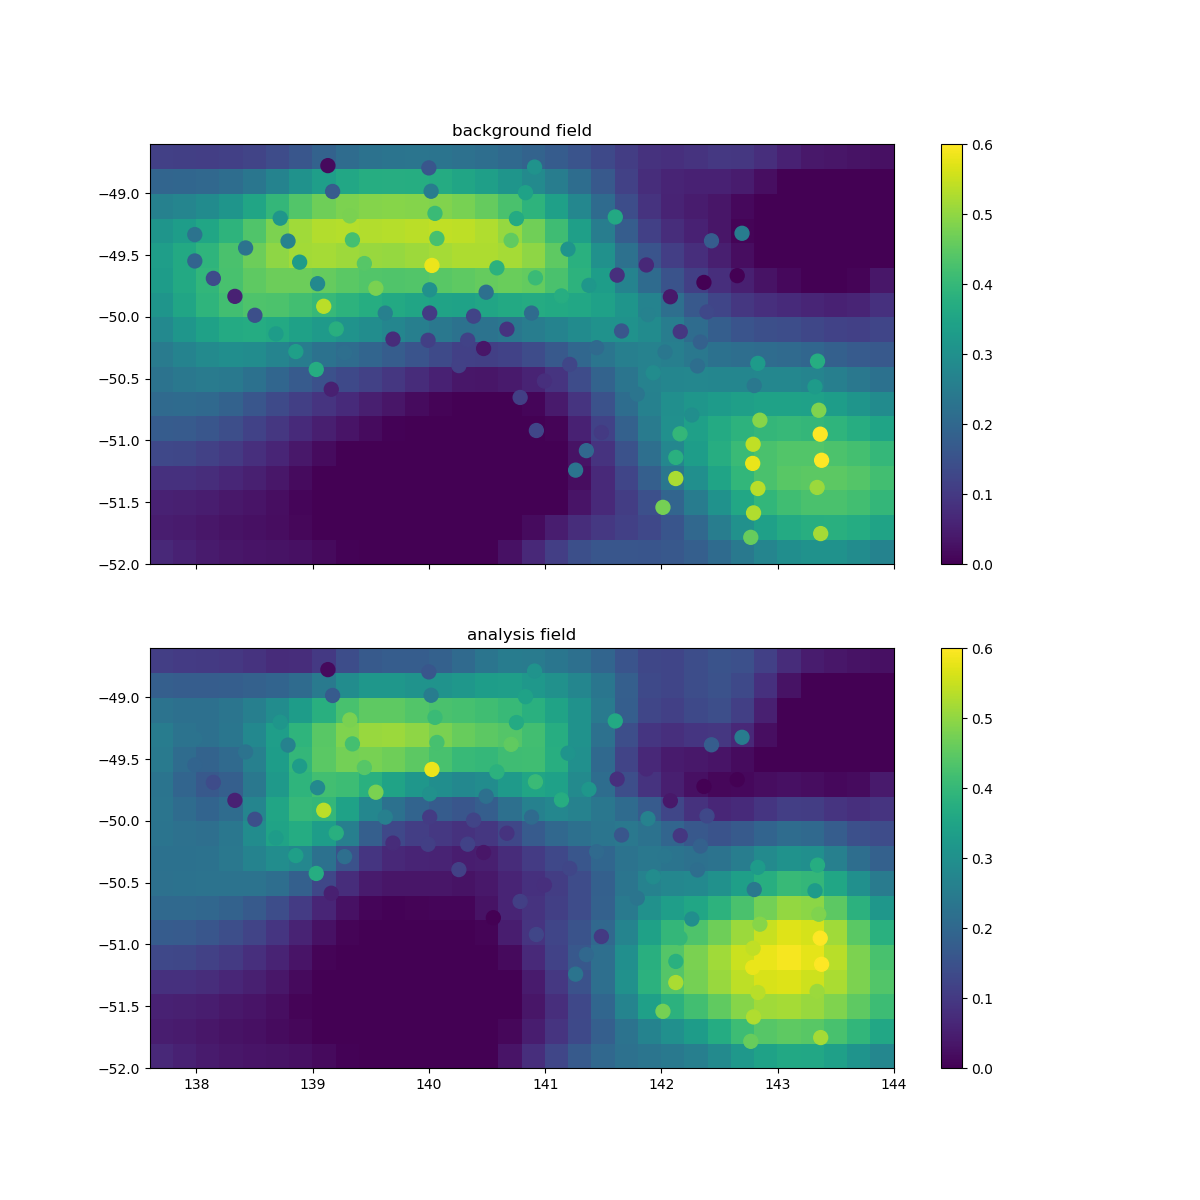

Text(0.5, 1.0, 'analysis field')

In [20]:
fig, ax = plt.subplots(2, 1, figsize=(12, 12), sharex=True)
vmin, vmax = 0, 0.6
ax[0].pcolor(xx, yy, u_b, vmin=vmin, vmax=vmax)
scat = ax[0].scatter(lon, lat, c=umldmean[2:], s=100, vmin=vmin, vmax=vmax)
plt.colorbar(scat, ax=ax[0])
ax[0].set_title('background field')

ax[1].pcolor(xx, yy, u_a, vmin=vmin, vmax=vmax)
scat = ax[1].scatter(lon, lat, c=umldmean[2:], s=100, vmin=vmin, vmax=vmax)
plt.colorbar(scat, ax=ax[1])
ax[1].set_title('analysis field')

And here, the v-component of the velocity vector.

<IPython.core.display.Javascript object>


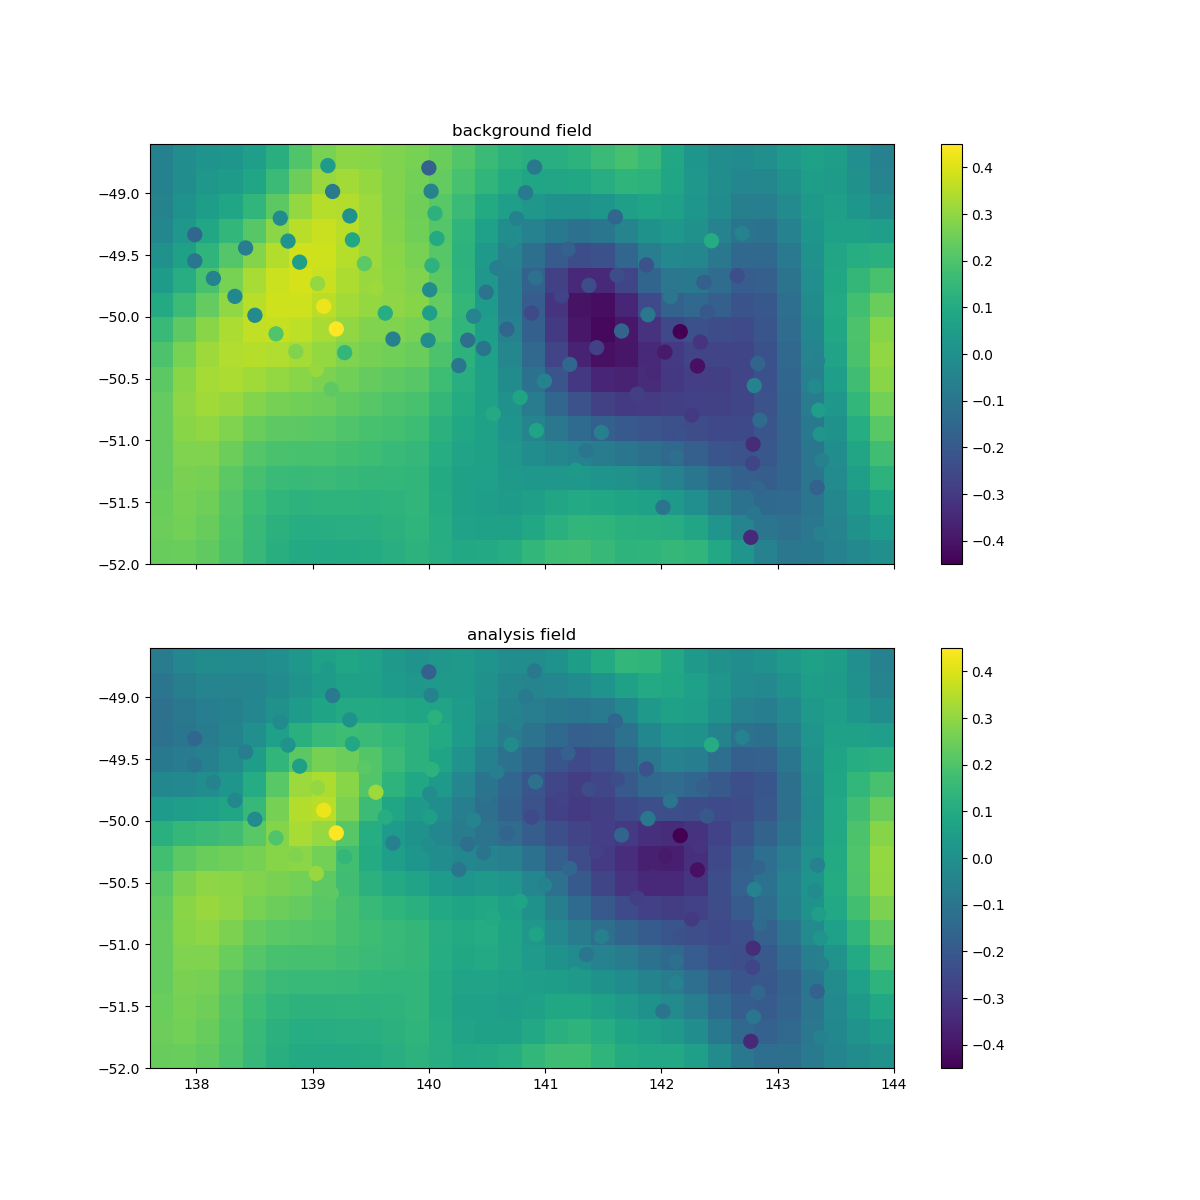

Text(0.5, 1.0, 'analysis field')

In [21]:
fig, ax = plt.subplots(2, 1, figsize=(12, 12), sharex=True)
vmin, vmax = -0.45, 0.45
ax[0].pcolor(xx, yy, v_b, vmin=vmin, vmax=vmax)
scat = ax[0].scatter(lon, lat, c=vmldmean[2:], s=100, vmin=vmin, vmax=vmax)
plt.colorbar(scat, ax=ax[0])
ax[0].set_title('background field')

vmin, vmax = -0.45, 0.45
ax[1].pcolor(xx, yy, v_a, vmin=vmin, vmax=vmax)
scat = ax[1].scatter(lon, lat, c=vmldmean[2:], s=100, vmin=vmin, vmax=vmax)
plt.colorbar(scat, ax=ax[1])
ax[1].set_title('analysis field')

## Multivariate OI with Dynamic Height observations

The next step is to calculate geostrophic velocities from dynamic height observations and SSH and SSH geostrophic velocties as a background field. The dynamic height is used in OI scheme to derive geostrophic u and v components.

In [23]:
from gsw import f

In [25]:
# monthly mean ssh
gslmmean = np.mean(ssh['GSL'][:], axis=0)
ummean = np.mean(ssh['UCUR'][:], axis=0)
vmmean = np.mean(ssh['VCUR'][:], axis=0)

mask = ~np.ma.masked_invalid(D_s[2:]).mask

# optimal interpolation of ADCP velocities with SSH geostrophic velocities as background field
UTM54 = pyproj.Proj('+proj=utm +zone=54F +south +ellps=WGS84 +datum=WGS84 +units=m +no_defs')
WGS84 = pyproj.Proj('+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs')

lonlon, latlat = np.meshgrid(loni, lati)

xx, yy = pyproj.transform(WGS84, UTM54, lonlon, latlat)
x, y = pyproj.transform(WGS84, UTM54, lon, lat)

xx, yy, x_b, x_a, _, B, A = OI(x[mask], y[mask], D_s[2:][mask],
                            Lx=(xx.max() - xx.min())/20, Ly=(yy.max() - yy.min())/20,
                            xx=xx, yy=yy, bg_fld=(gslmmean, ummean, vmmean), mvoi='geostrophy', f_cor=f(latlat)/2)

# vmagmld_a = np.sqrt(u_a**2 + v_a**2)

In [26]:
print(ssh['GSL'],'\n\n', ssh['GSLA'])

<class 'netCDF4._netCDF4.Variable'>
float64 GSL(TIME, LATITUDE, LONGITUDE)
    long_name: gridded sea level
    standard_name: sea_surface_height_above_geoid
    description: GSLA + OFAM3 mean dynamic height 
    units: m
    coordinates: TIME LATITUDE LONGITUDE
    _FillValue: -4.999923702562068
    missing_value: -4.999923702562068
unlimited dimensions: TIME
current shape = (15, 18, 33)
filling on 

 <class 'netCDF4._netCDF4.Variable'>
float64 GSLA(TIME, LATITUDE, LONGITUDE)
    long_name: gridded (adjusted) sea level anomaly 
    standard_name: sea_surface_height_above_sea_level
    description: Altimeter and tidegauge estimates of adjusted sea level anomaly mapped onto a grid using optimal interpolation (OI). For details of  the temporal and spatial covariance functions of the OI see the Reference. The anomaly field is mapped because the geoid is not known to sufficient precision, obliging us to remove the time-mean from all sea level observations. Sea level minus the tides and inv

**Question**
1. I used GSL instead of GSLA, to be in same order of magnitude as Dynamic height from observations, is that okay looking at the description of the variables above?

The covariance between the Dynamic Height and the geostrophic u and v components, the covariances between the u, and v components and the variance between p, u and v are shown below.

<IPython.core.display.Javascript object>


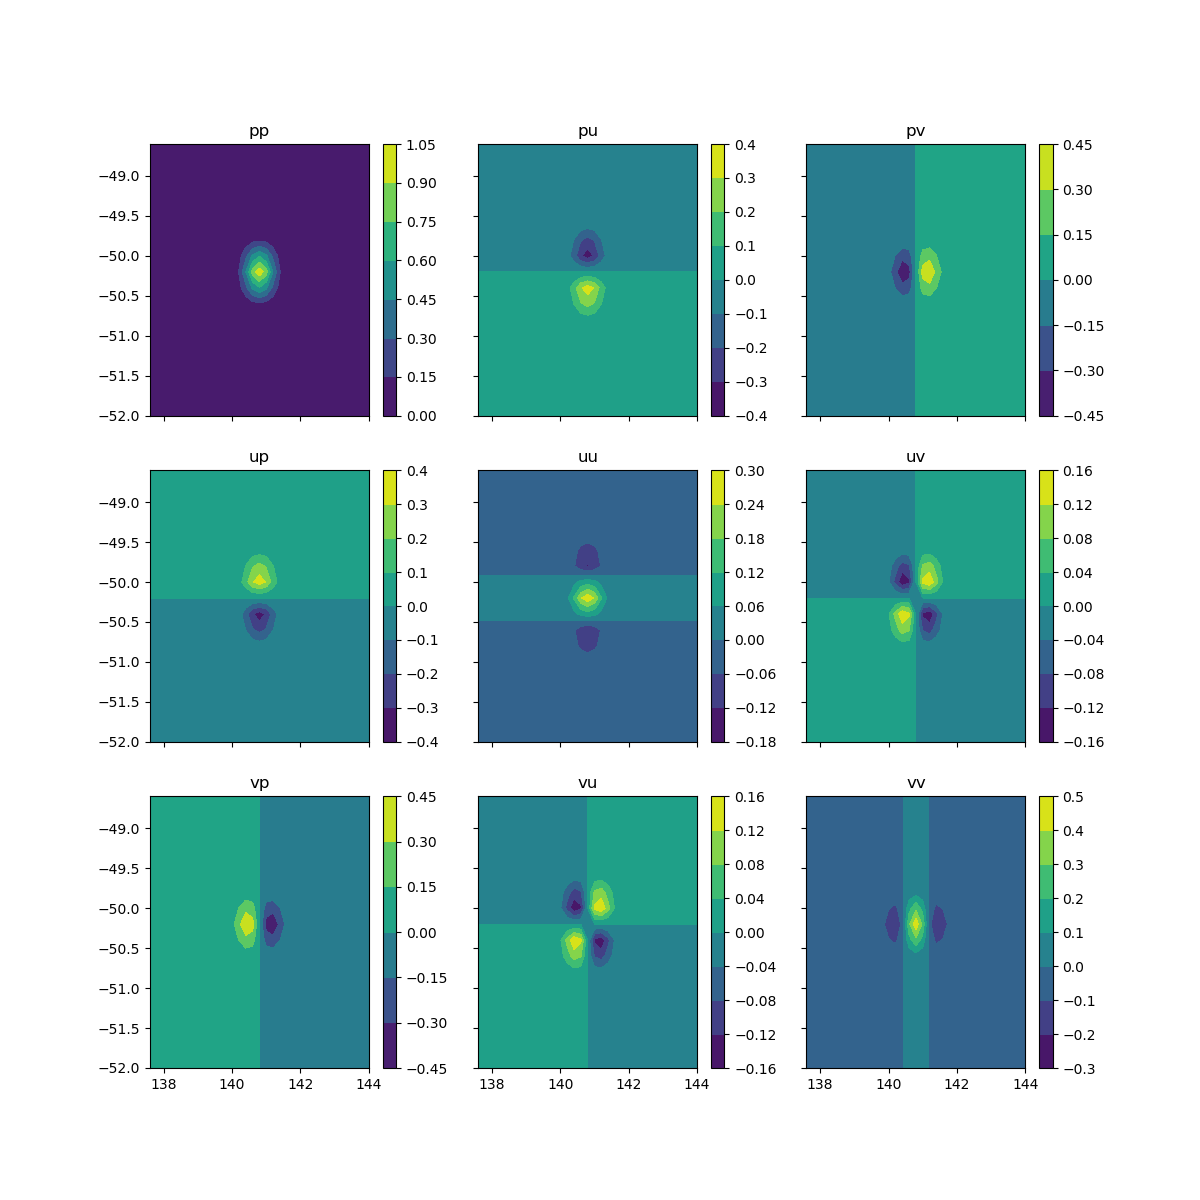

In [27]:
ny, nx = xx.shape 
# plot covariance matrices
var = ['p', 'u', 'v']
nvar = len(var)
coord = (int(np.floor(ny/2)), int(np.floor(nx/2)))
fig, ax = plt.subplots(nvar, nvar, figsize=(12, 12), sharex=True, sharey=True)
for ivar in range(nvar):
    for jvar in range(nvar):
        BB = np.reshape(B[ivar::nvar, jvar::nvar], (ny, nx, ny, nx))
        BBi = np.ma.masked_invalid(BB[coord[0], coord[1], :, :])
        conf = ax[ivar, jvar].contourf(lonlon, latlat, BBi)
        ax[ivar, jvar].set_title(var[ivar] + var[jvar])
        # ax[ivar, jvar].set_xlim([-np.sqrt(2)*Lx, np.sqrt(2)*Lx])
        # ax[ivar, jvar].set_ylim([-np.sqrt(2)*Lx, np.sqrt(2)*Lx])
        plt.colorbar(conf, ax=ax[ivar, jvar])

<IPython.core.display.Javascript object>


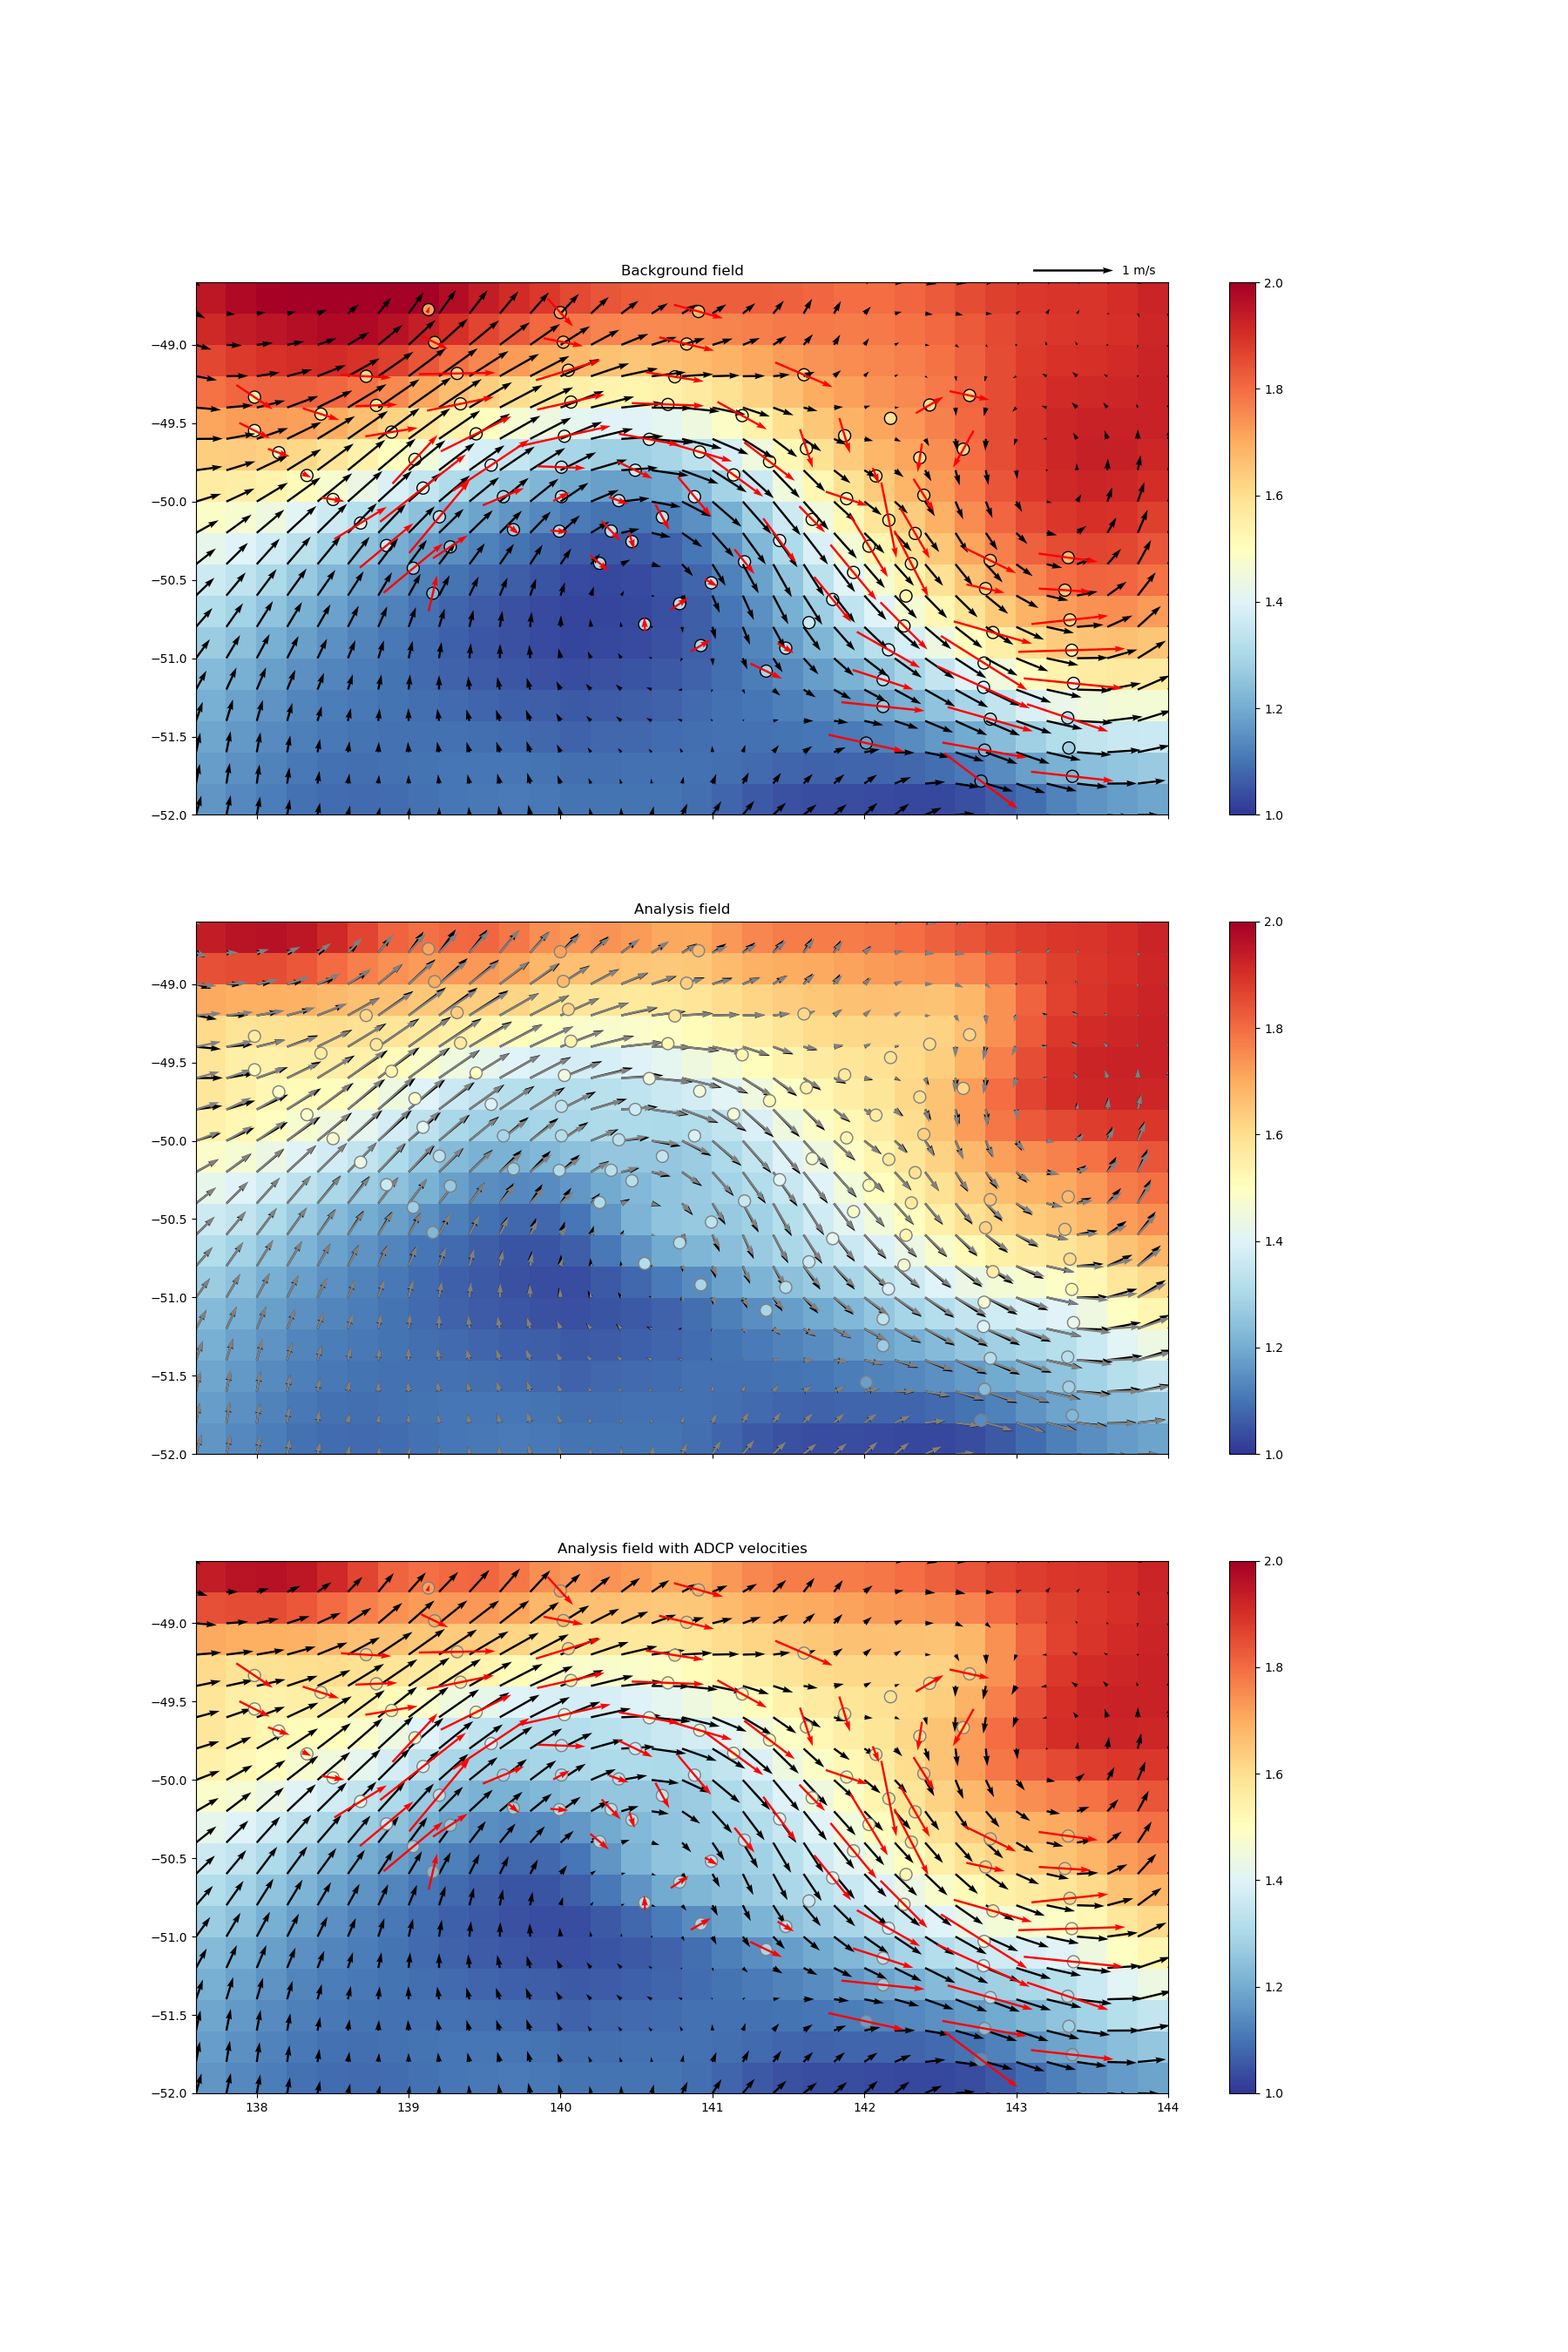

Text(0.5, 1.0, 'Analysis field with ADCP velocities')

In [29]:
fig, ax = plt.subplots(3, 1, figsize=(18, 27), sharex=True)
vmin, vmax = 1,2 #np.nanmin(D_s[2:]), np.nanmax(D_s[2:])

# Dynamic heighy background field
pcol = ax[0].pcolor(lonlon, latlat, x_b[0], vmin=vmin, vmax=vmax, cmap=plt.cm.RdYlBu_r)

# Dynamic height measurements
ax[0].scatter(lon[mask], lat[mask], c=D_s[2:][mask], vmin=vmin, vmax=vmax, cmap=plt.cm.RdYlBu_r, edgecolors='k', s=100)
plt.colorbar(pcol, ax=ax[0])

# Monthly mean geostropic velocity vectors from SSH
qb = ax[0].quiver(lonlon, latlat, x_b[1], x_b[2], units='inches', width=0.002*12)
ax[0].quiverkey(qb, 0.71, 0.885, 1, '1 m/s', labelpos='E',
                coordinates='figure', fontproperties={'size': 'medium'})

# Velocity vectors ADCP mixed layer depth
ax[0].quiver(lon[mask], lat[mask], 
                 umldmean[2:][mask], vmldmean[2:][mask], color='r', 
                 pivot='mid', units='inches', width=0.002*12, zorder=4)#)

ax[0].set_title('Background field')


# Dynamic height analysis field
pcol = ax[1].pcolor(lonlon, latlat, x_a[0], vmin=vmin, vmax=vmax, cmap=plt.cm.RdYlBu_r, zorder=0)
# pcol = ax[1].contourf(xx, yy, x_a[0], np.linspace(vmin, vmax, 10), cmap=plt.cm.RdYlBu_r, zorder=0)

# # Dynamic height measurements
ax[1].scatter(lon[mask], lat[mask], c=D_s[2:][mask], vmin=vmin, vmax=vmax, cmap=plt.cm.RdYlBu_r, 
              edgecolors='gray', s=100, zorder=2)
plt.colorbar(pcol, ax=ax[1])

# Monthly mean geostropic velocity vectors from SSH
qb = ax[1].quiver(lonlon, latlat, ummean, vmmean, color='k', units='inches', width=0.002*12)

# Velocity vectors analysis field
ax[1].quiver(lonlon, latlat, x_a[1], x_a[2], color='gray', units='inches', width=0.002*12)

ax[1].set_title('Analysis field')


# Dynamic height analysis field
pcol = ax[2].pcolor(lonlon, latlat, x_a[0], vmin=vmin, vmax=vmax, cmap=plt.cm.RdYlBu_r, zorder=0)

# Dynamic height measurements
ax[2].scatter(lon[mask], lat[mask], c=D_s[2:][mask], 
              vmin=vmin, vmax=vmax, cmap=plt.cm.RdYlBu_r, edgecolors='gray', s=100, zorder=2)
plt.colorbar(pcol, ax=ax[2])

# Velocity vectors analysis field
qb = ax[2].quiver(lonlon, latlat, x_a[1], x_a[2], color='k', units='inches', width=0.002*12)

# Velocity vectors ADCP mixed layer depth
ax[2].quiver(lon[mask], lat[mask], 
                 umldmean[2:][mask], vmldmean[2:][mask], color='r', 
                 pivot='mid', units='inches', width=0.002*12, zorder=4)#)

ax[2].set_title('Analysis field with ADCP velocities')


In [30]:
print('u_b: ', np.mean(x_b[1]), 'v_b: ', np.mean(x_b[2]), 
      'u_a: ', np.mean(x_a[1]), 'v_a: ', np.mean(x_a[2]), 
      np.mean(ummean), np.mean(vmmean))


u_b:  0.19011141361204179 v_b:  0.06862977662422218 u_a:  0.1889340851613334 v_a:  0.06769069979448539 0.19011141361204179 0.06862977662422218


## Relative vorticity

$$\nabla\cdot\vec{u} \approx \zeta = \frac{\partial v}{\partial x} - \frac{\partial u}{\partial y} $$

<IPython.core.display.Javascript object>


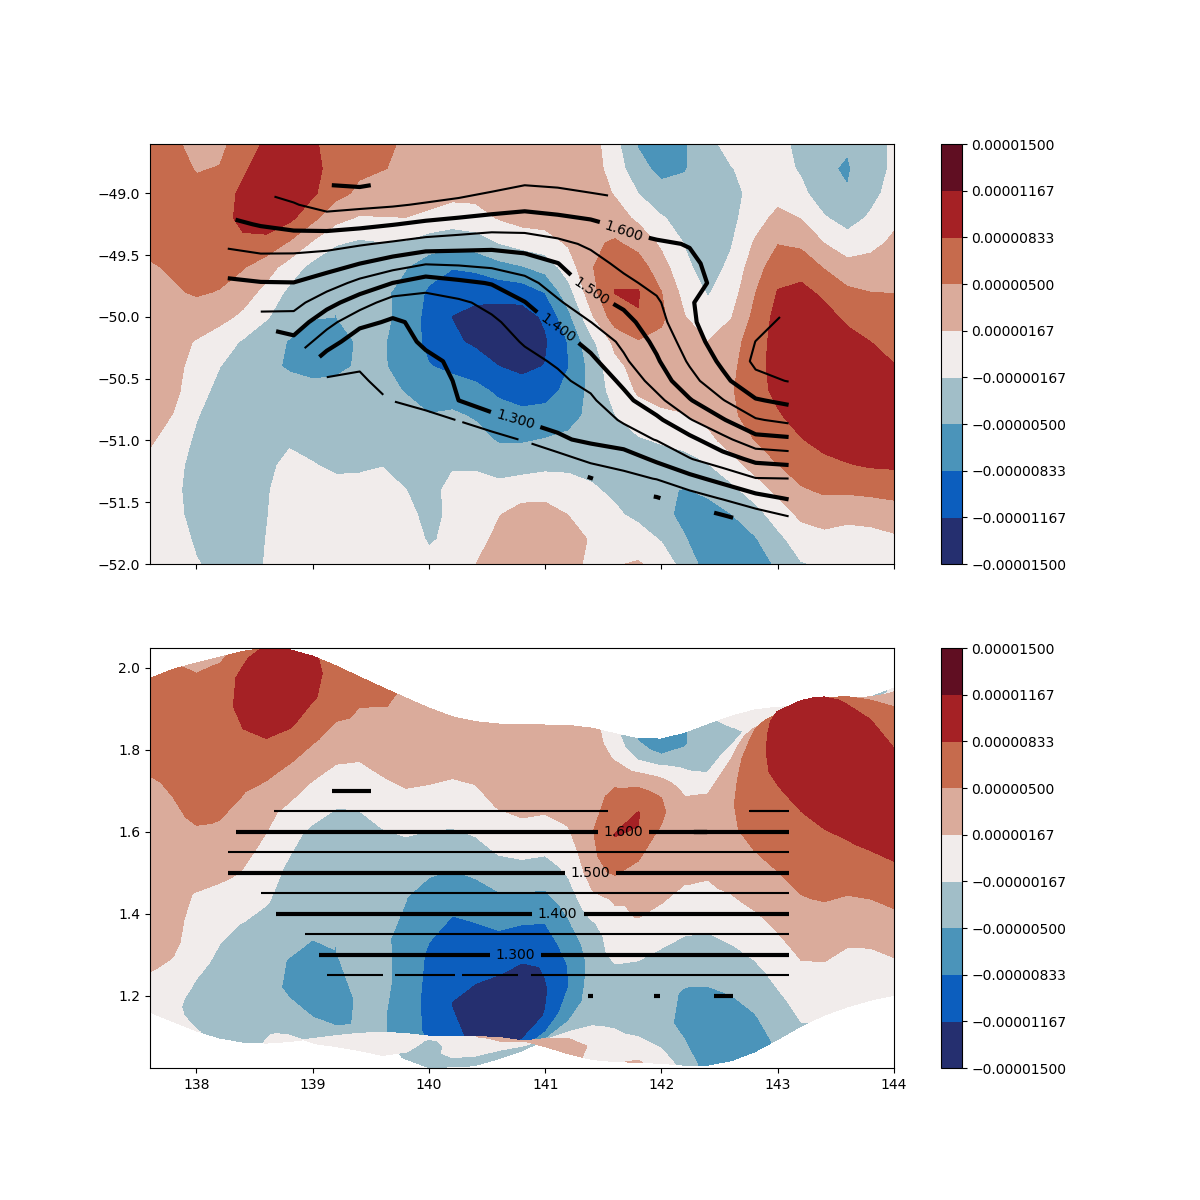

In [31]:
dvdx = np.gradient(x_b[2])[1] / np.gradient(xx)[1]
dudy = np.gradient(x_b[1])[0] / np.gradient(yy)[0]

zeta = dvdx - dudy

step = 0.05
xmin, xmax = math.floor(np.nanmin(D_sgrd)/step)*step, math.ceil(np.nanmax(D_sgrd)/step)*step
nsteps = int((xmax - xmin) / step) + 2
bounds = np.linspace(xmin, xmax, nsteps)

fig, ax = plt.subplots(2, 1, figsize=(12, 12), sharex=True)
vmin, vmax = -1.5e-5, 1.5e-5
cf = ax[0].contourf(lonlon, latlat, zeta, np.linspace(vmin, vmax, 10), cmap=cmo.cm.balance)
plt.colorbar(cf, ax=ax[0])
ct = ax[0].contour(xxD, yyD, D_sgrd, bounds, colors='k')
dh_cts(ct, bounds, ax=ax[0], start=1, step=2)

cf = ax[1].contourf(lonlon, x_b[0], zeta, np.linspace(vmin, vmax, 10), cmap=cmo.cm.balance)
plt.colorbar(cf, ax=ax[1])
ct = ax[1].contour(xxD, D_sgrd, D_sgrd, bounds, colors='k')
dh_cts(ct, bounds, ax=ax[1], start=1, step=2)

## Divergence

$$ \nabla\cdot\vec{u} = \frac{\partial u}{\partial x} + \frac{\partial v}{\partial y} + \frac{\partial w}{\partial z} = 0 $$

<IPython.core.display.Javascript object>


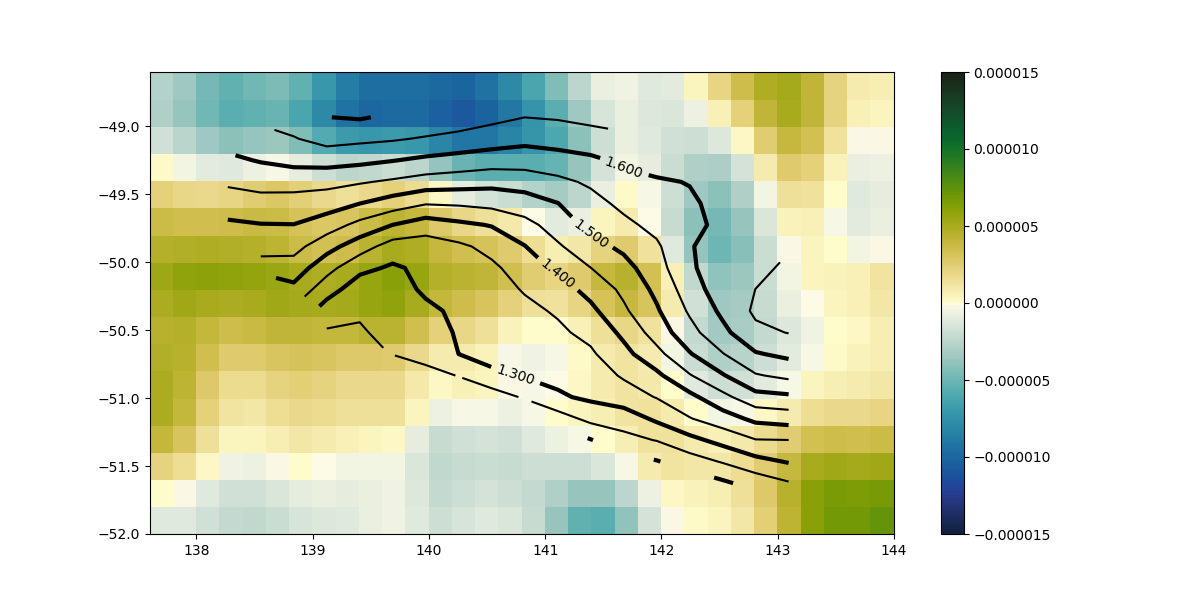

In [32]:
import cmocean
dudx = np.gradient(x_b[1])[0] / np.gradient(xx)[1]
dvdy = np.gradient(x_b[2])[1] / np.gradient(yy)[0]

div = dudx + dvdy

fig, ax = plt.subplots(figsize=(12, 6))
vmin, vmax = -1.5e-5, 1.5e-5
# cf = ax.contourf(lonlon, latlat, div, np.linspace(vmin, vmax, 10), cmap=cmocean.cm.delta)
pcol = ax.pcolor(lonlon, latlat, div, cmap=cmocean.cm.delta, vmin=vmin, vmax=vmax)
plt.colorbar(pcol)
ct = ax.contour(xxD, yyD, D_sgrd, bounds, colors='k')
dh_cts(ct, bounds, start=1, step=2)